In [4]:
import geopandas as gpd
from shapely.geometry import box
import numpy as np

pois = gpd.read_file('../west-midlands-latest-free/gis_osm_pois_a_free_1.shp')


# Use the existing pois layer to get the bounding box
pois = pois.to_crs(epsg=27700)
minx, miny, maxx, maxy = pois.total_bounds

# Set grid size (in meters)
cell_size = 500

# Generate grid
grid_cells = []
for x0 in np.arange(minx, maxx, cell_size):
    for y0 in np.arange(miny, maxy, cell_size):
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        grid_cells.append(box(x0, y0, x1, y1))

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=pois.crs)


In [ ]:
import pandas as pd

# Ensure CRS match
grid = grid.to_crs(pois.crs)

# Step 1: Spatial join POIs to grid
joined = gpd.sjoin(pois[["geometry", "fclass"]], grid, how="inner", predicate="within")

# Step 2: Group by grid cell and count most common fclass
# joined.index_right gives the index of the grid cell each POI falls into
most_common_pois = (
    joined.groupby("index_right")["fclass"]
    .agg(lambda x: x.value_counts().index[0])  # most common
    .rename("most_common_poi_type")
)

# Step 3: Assign the label to the grid
grid["most_common_poi_type"] = grid.index.map(most_common_pois)


In [ ]:
print(grid[["most_common_poi_type"]].value_counts().head())


most_common_poi_type
pitch                   447
school                  241
pub                     222
park                    187
playground              171
Name: count, dtype: int64


In [ ]:
# How many samples have valid labels?
print(f"Labeled cells: {grid['most_common_poi_type'].notnull().sum()}")

# How many POI types?
print("Unique POI types (labels):", grid["most_common_poi_type"].nunique())


Labeled cells: 2300
Unique POI types (labels): 84


In [ ]:
poi_counts = (
    joined.groupby("index_right")
    .size()
    .rename("poi_count")
)


In [ ]:
poi_diversity = (
    joined.groupby("index_right")["fclass"]
    .nunique()
    .rename("poi_diversity")
)


In [ ]:
# Assign to grid
grid["poi_count"] = grid.index.map(poi_counts)
grid["poi_diversity"] = grid.index.map(poi_diversity)

# Fill missing (e.g., empty cells with 0)
grid["poi_count"] = grid["poi_count"].fillna(0).astype(int)
grid["poi_diversity"] = grid["poi_diversity"].fillna(0).astype(int)


         poi_count  poi_diversity
count  8175.000000    8175.000000
mean      1.368196       0.937248
std       4.649808       2.478160
min       0.000000       0.000000
25%       0.000000       0.000000
50%       0.000000       0.000000
75%       1.000000       1.000000
max      94.000000      28.000000


<Axes: >

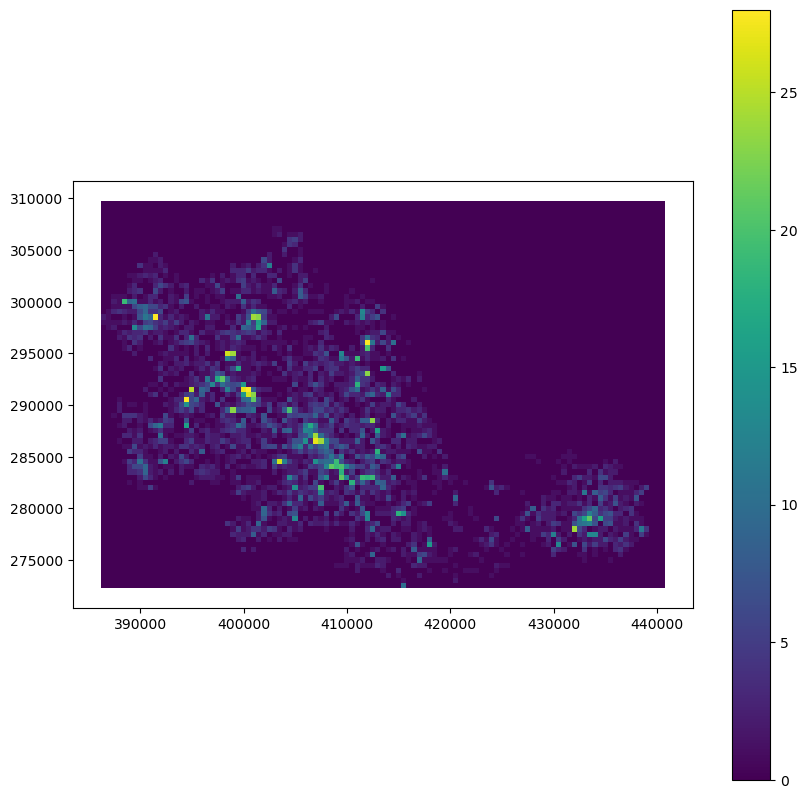

In [ ]:
print(grid[["poi_count", "poi_diversity"]].describe())

# Quick visual check
grid.plot(column="poi_diversity", legend=True, figsize=(10, 10))


In [ ]:
# Drop cells without a label
train_df = grid.dropna(subset=["most_common_poi_type"]).copy()

# Optional: drop cells with 0 POIs — they add noise
train_df = train_df[train_df["poi_count"] > 0]


In [ ]:
print(train_df["most_common_poi_type"].value_counts().head(10))


most_common_poi_type
pitch            447
school           241
pub              222
park             187
playground       171
fast_food         99
convenience       93
swimming_pool     87
doctors           63
supermarket       56
Name: count, dtype: int64


In [ ]:
landuse = gpd.read_file('../west-midlands-latest-free/gis_osm_landuse_a_free_1.shp')
landuse = landuse.to_crs(grid.crs)


In [ ]:
# Join landuse polygons to grid
landuse_joined = gpd.sjoin(landuse[["geometry", "fclass"]], grid, how="inner", predicate="intersects")

# Group by grid index and count types
landuse_counts = pd.crosstab(landuse_joined["index_right"], landuse_joined["fclass"])

# Join back to grid
grid_landuse = grid.join(landuse_counts, how="left")
grid_landuse.fillna(0, inplace=True)


In [ ]:
# Keep only cells that have a label
train_df = grid_landuse.dropna(subset=["most_common_poi_type"]).copy()


In [ ]:
train_df[["residential", "commercial", "park"]].describe()


,residential,commercial,park
count,8175.000000,8175.000000,8175.000000
mean,2.454434,0.089419,0.340795
std,3.935788,0.477232,0.797027
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,4.000000,0.000000,0.000000
max,85.000000,11.000000,19.000000


In [ ]:
places = gpd.read_file('../west-midlands-latest-free/gis_osm_places_a_free_1.shp')
# 1. Make sure CRS matches
places = places.to_crs(grid.crs)

# 2. Spatial join: grid cells with places
places_joined = gpd.sjoin(grid[["geometry"]], places[["geometry", "fclass"]], how="left", predicate="intersects")

# 3. For each grid cell, pick the first (or most common) place type
place_type_by_cell = (
    places_joined.groupby(places_joined.index)["fclass"]
    .agg(lambda x: x.iloc[0] if len(x) > 0 else "unknown")
)

# 4. Assign back to grid
grid["place_type"] = grid.index.map(place_type_by_cell)

# 5. Fill empty values (in case some cells didn’t match any place)
grid["place_type"] = grid["place_type"].fillna("unknown")




In [ ]:
grid = pd.get_dummies(grid, columns=["place_type"], drop_first=True)


In [ ]:
train_df = grid.dropna(subset=["most_common_poi_type"]).copy()

# Filter rare classes (fewer than 5 samples)
valid_classes = train_df["most_common_poi_type"].value_counts()
train_df = train_df[train_df["most_common_poi_type"].isin(valid_classes[valid_classes >= 5].index)]

# Encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df["label_encoded"] = le.fit_transform(train_df["most_common_poi_type"])

# Define features and target
X = train_df.drop(columns=["geometry", "most_common_poi_type", "label_encoded"])
y = train_df["label_encoded"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
from sklearn.preprocessing import LabelEncoder
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le.inverse_transform(sorted(y.unique())),
    zero_division=0
))


Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 2 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]

Classification Report:
                  precision    recall  f1-score   support

      attraction       0.00      0.00      0.00         1
            bank       0.00      0.00      0.00         2
            cafe       0.33      0.17      0.22         6
  car_dealership       0.00      0.00      0.00         9
        car_wash       0.00      0.00      0.00         2
          clinic       0.00      0.00      0.00         1
         clothes       0.00      0.00      0.00         3
community_centre       0.00      0.00      0.00         7
     convenience       0.00      0.00      0.00        19
         dentist       0.00      0.00      0.00         2
         doctors       0.00      0.00      0.00        13
    doityourself       0.00      0.00      0.00         3
       fast_food       0.17      0.15      0.16        20
    fire_station       0.

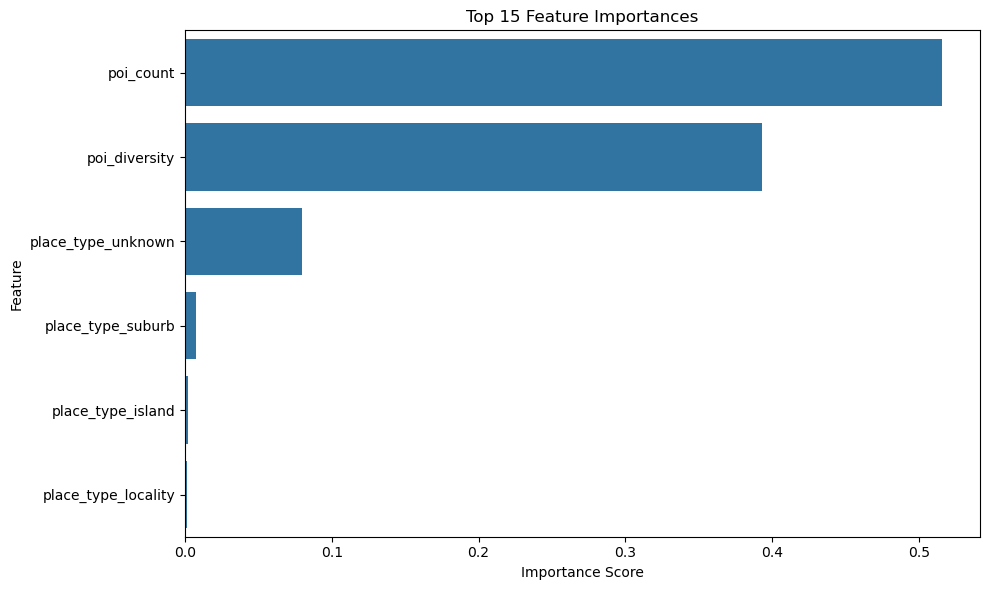

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = pd.Series(clf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# Filter top 15 classes only
top_classes = train_df["most_common_poi_type"].value_counts().head(15).index
train_df_top = train_df[train_df["most_common_poi_type"].isin(top_classes)].copy()


In [ ]:
from sklearn.preprocessing import LabelEncoder

le_top = LabelEncoder()
train_df_top["label_encoded"] = le_top.fit_transform(train_df_top["most_common_poi_type"])


In [ ]:
X_top = train_df_top.drop(columns=["geometry", "most_common_poi_type", "label_encoded"])
y_top = train_df_top["label_encoded"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_top, y_top, stratify=y_top, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le_top.inverse_transform(sorted(y_top.unique())),
    zero_division=0
))


Confusion Matrix:
[[ 1  2  0  0  2  1  0  0  1  0  0  0  0  0  2]
 [ 0  2  0  0  0  0  2  0  0  0  0  0  0  0  3]
 [ 1  2  1  1  1  1  3  0  3  0  0  0  0  0  6]
 [ 1  2  1  0  1  0  5  0  0  0  0  0  0  0  3]
 [ 2  2  3  0  7  1  1  0  1  0  0  2  0  0  1]
 [ 0  1  1  0  1  1  1  1  0  0  0  2  0  0  0]
 [ 2  1  0  0  0  0  1  0  0  0  0  1  0  0  3]
 [ 7 11  0  0  2  0  2  1  6  1  1  1  0  0  5]
 [15  7  0  1  2  2  5  2 24  5  1  2  0  0 24]
 [ 3  4  1  2  0  2  2  2  4  1  0  0  0  0 13]
 [ 6 16  0  2  0  3  4  0  0  0  1  0  0  1 12]
 [ 0  2  0  0  2  0  0  0  1  0  0  3  0  0  3]
 [ 5 13  1  1  0  2  4  0  3  2  1  0  0  0 16]
 [ 1  4  0  1  0  0  1  0  0  0  0  0  0  1  3]
 [ 3  1  0  0  0  0  0  0  2  0  0  0  0  0 11]]

Classification Report:
                  precision    recall  f1-score   support

  car_dealership       0.02      0.11      0.04         9
community_centre       0.03      0.29      0.05         7
     convenience       0.12      0.05      0.07        19
    

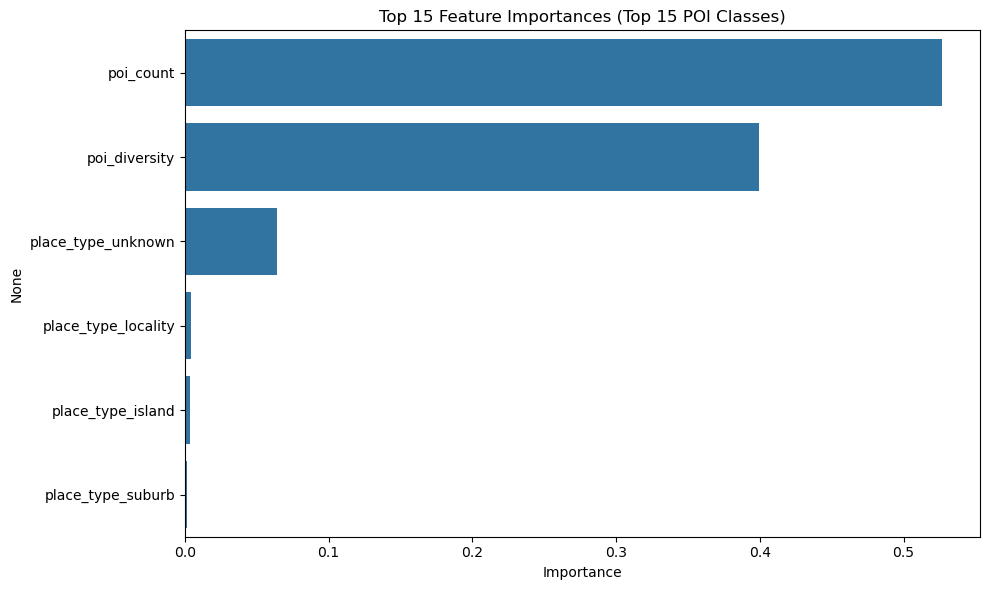

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(clf.feature_importances_, index=X_top.columns)
top_feats = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feats.values, y=top_feats.index)
plt.title("Top 15 Feature Importances (Top 15 POI Classes)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

labels = le_top.inverse_transform(sorted(y_top.unique()))
acc_per_class = pd.DataFrame({
    "POI Type": labels,
    "Accuracy": [
        accuracy_score(y_test[y_test == i], y_pred[y_test == i])
        for i in sorted(y_top.unique())
    ]
}).sort_values("Accuracy", ascending=False)

print("\nTop Performing Classes:")
print(acc_per_class.head(5))

print("\nChallenging Classes:")
print(acc_per_class.tail(5))



Top Performing Classes:
            POI Type  Accuracy
14     swimming_pool  0.647059
4          fast_food  0.350000
1   community_centre  0.285714
11        restaurant  0.272727
8              pitch  0.266667

Challenging Classes:
      POI Type  Accuracy
9   playground  0.029412
7         park  0.027027
10         pub  0.022222
3      doctors  0.000000
12      school  0.000000


### Trying XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softprob",  # for multi-class classification
    num_class=len(le_top.classes_),
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_clf.fit(X_train, y_train)


/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:17:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, num_class=15, ...)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_xgb = xgb_clf.predict(X_test)

print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report (XGBoost):")
print(classification_report(
    y_test, y_pred_xgb,
    target_names=le_top.inverse_transform(sorted(y_top.unique())),
    zero_division=0
))


Confusion Matrix (XGBoost):
[[ 0  0  0  0  2  0  0  0  3  0  1  0  3  0  0]
 [ 0  0  0  0  0  0  0  1  2  0  1  0  3  0  0]
 [ 0  0  1  0  1  0  0  2  6  1  0  0  8  0  0]
 [ 0  0  0  0  1  0  0  0  4  0  2  0  6  0  0]
 [ 0  0  3  0  6  0  0  0  6  0  1  1  3  0  0]
 [ 0  0  1  0  4  1  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  2  0  1  0  2  0  0]
 [ 1  0  0  0  1  0  0  7 13  0  8  0  7  0  0]
 [ 0  0  2  0  2  1  0  1 68  2  4  0 10  0  0]
 [ 0  0  0  0  1  1  0  2 18  1  3  1  7  0  0]
 [ 0  0  0  0  1  1  0  4 13  3 10  0 13  0  0]
 [ 0  0  0  0  4  0  0  1  4  0  0  1  1  0  0]
 [ 0  0  1  0  0  0  0  7 19  1  4  0 16  0  0]
 [ 0  0  0  0  0  0  0  3  4  1  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  1  0  4  0  0]]

Classification Report (XGBoost):
                  precision    recall  f1-score   support

  car_dealership       0.00      0.00      0.00         9
community_centre       0.00      0.00      0.00         7
     convenience       0.12      0.05     

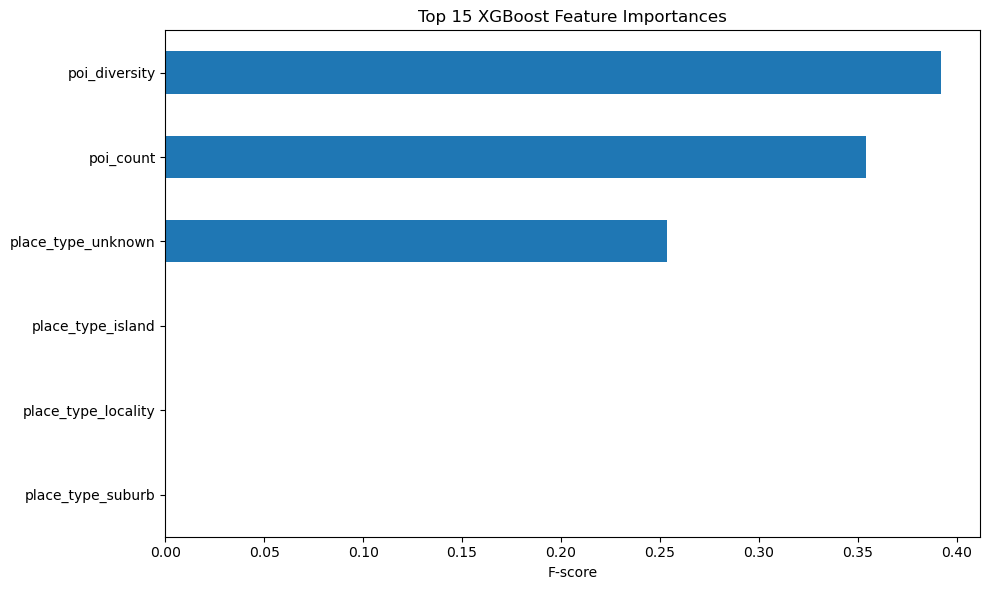

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

xgb_importance = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
xgb_top_features = xgb_importance.sort_values(ascending=False).head(15)

xgb_top_features.plot(kind='barh', figsize=(10, 6))
plt.title("Top 15 XGBoost Feature Importances")
plt.xlabel("F-score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
